In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import Levenshtein

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ali/nltk_data...


True

In [6]:
ALPHA = 0.5

In [9]:
def calculate_levenshtein_accuracy(true_sentence, generated_sentence):
    distance = Levenshtein.distance(true_sentence, generated_sentence)
    max_len = max(len(true_sentence), len(generated_sentence))
    return 1 - (distance / max_len)

def calculate_bleu_score(true_sentence, generated_sentence):
    # Use a smoothing function to avoid BLEU score being zero
    smoothing_function = SmoothingFunction().method1
    return sentence_bleu(
        [true_sentence.split()], 
        generated_sentence.split(), 
        smoothing_function=smoothing_function
    )

def calculate_rouge_scores(true_sentence, generated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, generated_sentence)
    rouge_scores = {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }
    return list(rouge_scores.values())

def calculate_meteor_score(true_sentence, generated_sentence):
    # Tokenize sentences
    reference_tokens = true_sentence.split()
    generated_tokens = generated_sentence.split()
    # Calculate METEOR score
    return meteor_score([reference_tokens], generated_tokens)

def combined_score(levenshtein_accuracy, bleu_score, alpha=ALPHA):
    return alpha * levenshtein_accuracy + (1 - alpha) * bleu_score

In [10]:
# test rouge
true_sentence = "The quick brown fox jumps over the lazy dog"
generated_sentence = "The quick brown fox jumps over the lazy dog"
rouge_scores = calculate_rouge_scores(true_sentence, generated_sentence)
print(rouge_scores)

[1.0, 1.0, 1.0]


In [11]:
model_map = {
    'base': 'B-CoAtNet',
    'llama3_2_1b': 'LLAMA-3.2-1B',
    'llama3_2_3b': 'LLAMA-3.2-3B',
    'llama3_1_8b': 'LLAMA-3.1-8B',
    # 'gpt-4o': 'GPT-4o',
    # 'echocrypt': 'Fine-tuned LLAMA-3.2-3B',
}

In [12]:
main_dir = '.'

In [20]:
# Data holder for plotting
results = []
file_counter = 0

for model_dir in os.listdir(main_dir):
    model_path = os.path.join(main_dir, model_dir)
    if os.path.isdir(model_path):
        for csv_file in os.listdir(model_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(model_path, csv_file)
                df = pd.read_csv(csv_path)
                nf = csv_file.replace('.csv', '')
                
                if nf == '0001_noise':
                    nf = 0.0001
                elif nf == '001_noise':
                    nf = 0.001
                elif nf == '002_noise':
                    nf = 0.002
                else: 
                    continue

                print(f"nf changed to {nf}")

                model_name = model_dir
                # Calculate average accuracy for each CSV (noise factor)
                lev_accuracies = []
                bleu_accuracies = []
                for _, row in df.iterrows():
                    true_sentence = row['True Sentence']
                    predicted_sentence = row['Predicted Sentence']
                    llm_sentence = row['LLM Sentence']
                    
                    base_leven = calculate_levenshtein_accuracy(true_sentence, predicted_sentence)
                    base_bleu = calculate_bleu_score(true_sentence, predicted_sentence)
                    base_combined = combined_score(base_leven, base_bleu)
                    base_meteor = calculate_meteor_score(true_sentence, predicted_sentence)
                    base_rouge1, base_rouge2, base_rougeL = calculate_rouge_scores(true_sentence, predicted_sentence)
                    
                    llm_leven = calculate_levenshtein_accuracy(true_sentence, llm_sentence)
                    llm_bleu = calculate_bleu_score(true_sentence, llm_sentence)
                    llm_combined = combined_score(llm_leven, llm_bleu)
                    llm_meteor = calculate_meteor_score(true_sentence, llm_sentence)
                    llm_rouge1, llm_rouge2, llm_rougeL = calculate_rouge_scores(true_sentence, llm_sentence)
                    
                    if file_counter < 3:
                        results.append({
                            'Model': model_map['base'], # CoAtNet
                            'Noise Factor': nf,
                            'Levenshtein Accuracy': base_leven,
                            'BLEU Accuracy': base_bleu,
                            'Meteor Score': base_meteor,
                            'Rouge-1': base_rouge1,
                            'Rouge-2': base_rouge2,
                            'Rouge-L': base_rougeL,
                            'Adjusted Accuracy': base_combined,
                        })
                    
                    results.append({
                        'Model': model_map[model_name], # LLM
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': llm_leven,
                        'BLEU Accuracy': llm_bleu,
                        'Meteor Score': llm_meteor,
                        'Rouge-1': llm_rouge1,
                        'Rouge-2': llm_rouge2,
                        'Rouge-L': llm_rougeL,
                        'Adjusted Accuracy': llm_combined,
                    })
        file_counter += 3


nf changed to 0.002
nf changed to 0.001
nf changed to 0.0001
nf changed to 0.002
nf changed to 0.001
nf changed to 0.0001
nf changed to 0.002
nf changed to 0.001
nf changed to 0.0001


In [19]:
results

[]

In [21]:
results_df = pd.DataFrame(results)
# re-order models based on model_map.values()
results_df['Model'] = pd.Categorical(results_df['Model'], model_map.values())
# results_df['Noise Factor'] = results_df['Noise Factor'].astype(str)
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,B-CoAtNet,0.0020,0.625000,0.000000,0.000000,0.000000,0.0,0.000000,0.312500
1,LLAMA-3.2-1B,0.0020,1.000000,1.000000,0.999878,1.000000,1.0,1.000000,1.000000
2,B-CoAtNet,0.0020,0.602151,0.018934,0.107914,0.222222,0.0,0.222222,0.310542
3,LLAMA-3.2-1B,0.0020,1.000000,1.000000,0.999818,1.000000,1.0,1.000000,1.000000
4,B-CoAtNet,0.0020,0.587302,0.021459,0.050505,0.105263,0.0,0.105263,0.304380
...,...,...,...,...,...,...,...,...,...
11995,LLAMA-3.1-8B,0.0001,1.000000,1.000000,0.998542,1.000000,1.0,1.000000,1.000000
11996,LLAMA-3.1-8B,0.0001,0.972603,0.701688,0.905455,0.909091,0.8,0.909091,0.837145
11997,LLAMA-3.1-8B,0.0001,1.000000,1.000000,0.999500,1.000000,1.0,1.000000,1.000000
11998,LLAMA-3.1-8B,0.0001,1.000000,1.000000,0.999500,1.000000,1.0,1.000000,1.000000


In [22]:

mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()

/tmp/ipykernel_1715033/2869310711.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()
/tmp/ipykernel_1715033/2869310711.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_df = results_df.groupby(['Model', 'Noise Factor']).std().reset_index()


In [24]:
mean_df.to_excel('mean.xlsx', index=False)
std_df.to_excel('std.xlsx', index=False)

In [12]:
df = mean_df.copy()
df2 = std_df.copy()

# Map Noise Factor to corresponding levels
noise_levels = {1.0: "Low", 1.5: "Mid", 2.0: "High"}
df["Noise Level"] = df["Noise Factor"].map(noise_levels)
df2["Noise Level"] = df2["Noise Factor"].map(noise_levels)

# Generate LaTeX table rows
def generate_latex_rows(df, std_df, metric_columns):
    latex_rows = []
    for metric in metric_columns:
        for noise_level in ["Low", "Mid", "High"]:
            subset = df[(df["Noise Level"] == noise_level) & (df["Model"] != "EchoCrypt")]
            subset_std = std_df[(std_df["Noise Level"] == noise_level) & (std_df["Model"] != "EchoCrypt")]
            row = f"        {metric} ({noise_level}) & " + " & ".join(
                f"{mean*100:.1f}\\% $\\pm$ {std*100:.1f}\\%" for mean, std in zip(subset[metric], subset_std[metric])
            ) + " \\\\"
            latex_rows.append(row)
    return "\n".join(latex_rows)

# Specify metric columns
metric_columns = ["BLEU Accuracy", "Meteor Score", "Rouge-1", "Rouge-2", "Rouge-L"]

# Generate LaTeX rows for the specified metrics
latex_rows = generate_latex_rows(df, df2, metric_columns)

# Print the rows
print(latex_rows)


        BLEU Accuracy (Low) & 58.9\% $\pm$ 27.9\% & 84.8\% $\pm$ 24.6\% & 95.0\% $\pm$ 12.0\% & 97.3\% $\pm$ 8.6\% & 99.0\% $\pm$ 5.4\% & 95.6\% $\pm$ 9.8\% \\
        BLEU Accuracy (Mid) & 7.2\% $\pm$ 8.4\% & 31.6\% $\pm$ 28.8\% & 56.7\% $\pm$ 28.6\% & 68.1\% $\pm$ 27.0\% & 92.2\% $\pm$ 14.3\% & 85.7\% $\pm$ 19.9\% \\
        BLEU Accuracy (High) & 2.7\% $\pm$ 3.1\% & 8.3\% $\pm$ 13.4\% & 21.4\% $\pm$ 22.9\% & 30.0\% $\pm$ 25.8\% & 76.4\% $\pm$ 25.1\% & 66.9\% $\pm$ 29.0\% \\
        Meteor Score (Low) & 76.8\% $\pm$ 17.5\% & 91.2\% $\pm$ 18.6\% & 97.8\% $\pm$ 6.1\% & 99.0\% $\pm$ 3.4\% & 99.6\% $\pm$ 2.1\% & 97.8\% $\pm$ 4.5\% \\
        Meteor Score (Mid) & 26.9\% $\pm$ 16.1\% & 54.8\% $\pm$ 28.4\% & 77.9\% $\pm$ 18.4\% & 84.6\% $\pm$ 15.4\% & 96.2\% $\pm$ 7.1\% & 93.3\% $\pm$ 10.2\% \\
        Meteor Score (High) & 11.0\% $\pm$ 10.2\% & 23.6\% $\pm$ 22.0\% & 47.8\% $\pm$ 23.4\% & 57.3\% $\pm$ 22.0\% & 88.1\% $\pm$ 14.6\% & 82.6\% $\pm$ 18.0\% \\
        Rouge-1 (Low) & 80.6\% $\pm$

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


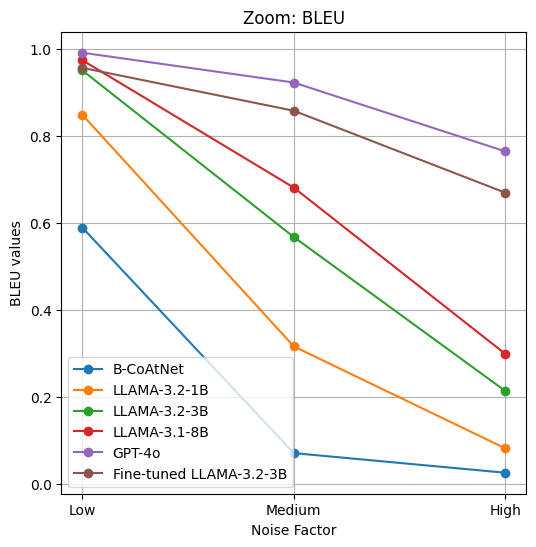

In [13]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["BLEU Accuracy"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: BLEU")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("BLEU values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


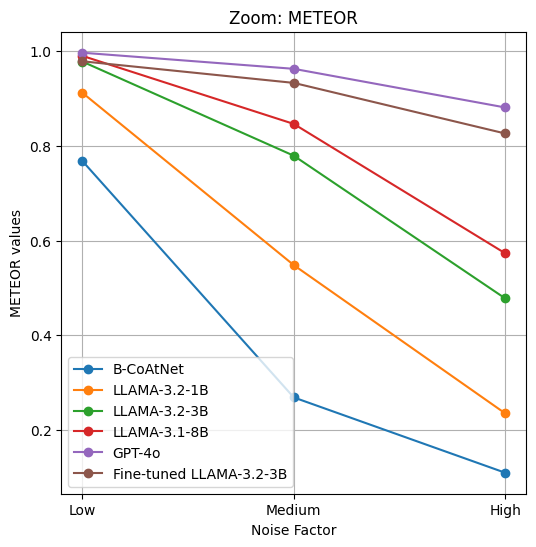

In [14]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Meteor Score"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: METEOR")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("METEOR values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


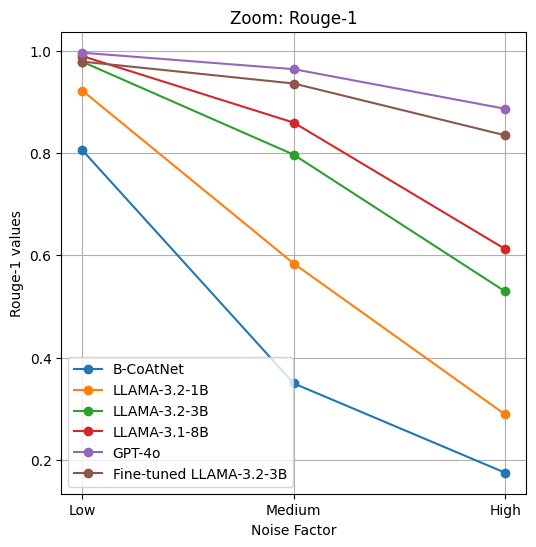

In [15]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-1"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-1")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("Rouge-1 values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


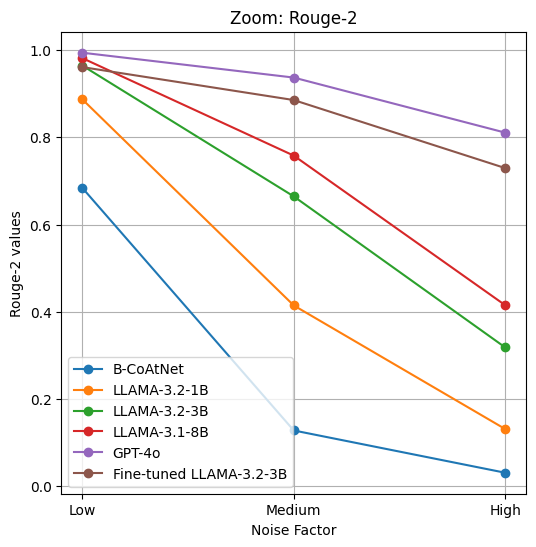

In [16]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-2"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-2")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("Rouge-2 values")
plt.legend()
plt.grid(True)
plt.show()

['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']
Categories (6, object): ['B-CoAtNet', 'LLAMA-3.2-1B', 'LLAMA-3.2-3B', 'LLAMA-3.1-8B', 'GPT-4o', 'Fine-tuned LLAMA-3.2-3B']


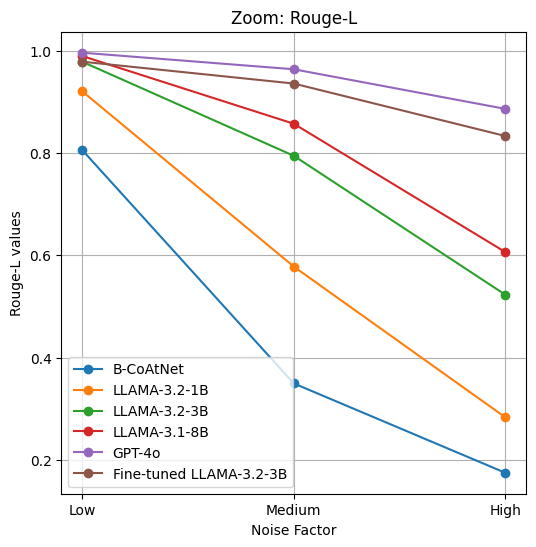

In [17]:
import math 

models = mean_df["Model"].unique()
print(models)
plt.figure(figsize=(6, 6))

for model in models:
    mean_subset = mean_df[mean_df["Model"] == model]
    std_subset = std_df[std_df["Model"] == model]
    
    # Extracting values and ensuring alignment
    x_values = mean_subset["Noise Factor"].values
    y_mean = mean_subset["Rouge-L"].values
    # y_std = std_subset["BLEU Accuracy"].values 
    y_std = 0
    
    # Calculating bounds
    lower_bound = y_mean - y_std
    upper_bound = y_mean + y_std
    
    # Plotting mean line
    plt.plot(x_values, y_mean, marker='o', label=model)
    
    # Adding shaded area
    plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.2)

plt.title("Zoom: Rouge-L")
plt.xlabel("Noise Factor")
plt.xticks([1.0, 1.5, 2.0], labels=["Low", "Medium", "High"])
plt.ylabel("Rouge-L values")
plt.legend()
plt.grid(True)
plt.show()

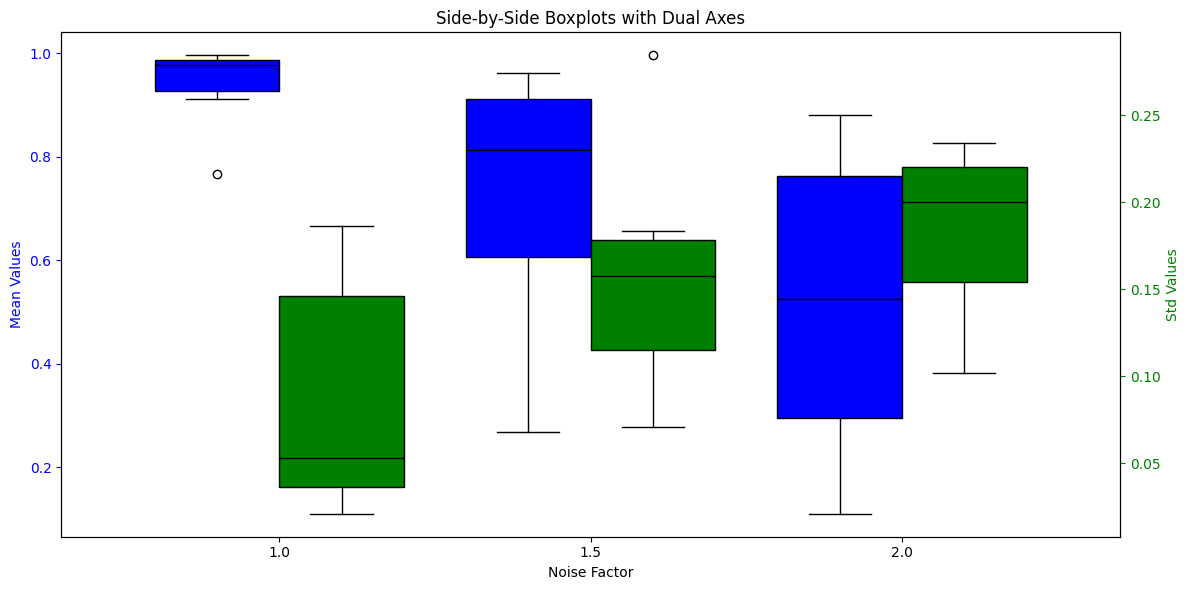

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Melt the dataframes for seaborn
mean_melted = mean_df.melt(id_vars=['Model', 'Noise Factor'], var_name='Metric', value_name='Mean')
std_melted = std_df.melt(id_vars=['Model', 'Noise Factor'], var_name='Metric', value_name='Std')

# Merge the mean and std dataframes
merged_df = pd.merge(mean_melted, std_melted, on=['Model', 'Noise Factor', 'Metric'])

# Filter for Meteor Score only
merged_df = merged_df[merged_df['Metric'] == 'Meteor Score']
noise_factors = sorted(merged_df['Noise Factor'].unique())

# Restructure the data for Mean and Std separately
mean_data = pd.DataFrame({'Noise Factor': merged_df['Noise Factor'], 'Value': merged_df['Mean']})
std_data = pd.DataFrame({'Noise Factor': merged_df['Noise Factor'], 'Value': merged_df['Std']})

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define offsets for side-by-side boxplots
x_positions = np.arange(len(noise_factors))
bar_width = 0.4

# Plot the Mean boxplots on the primary y-axis
ax1.boxplot(
    [mean_data[mean_data['Noise Factor'] == nf]['Value'] for nf in noise_factors],
    positions=x_positions - bar_width / 2,
    widths=bar_width,
    patch_artist=True,
    boxprops=dict(facecolor='blue'),
    medianprops=dict(color='black')
)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the Std boxplots on the secondary y-axis
ax2.boxplot(
    [std_data[std_data['Noise Factor'] == nf]['Value'] for nf in noise_factors],
    positions=x_positions + bar_width / 2,
    widths=bar_width,
    patch_artist=True,
    boxprops=dict(facecolor='green'),
    medianprops=dict(color='black')
)

# Customize the axes
ax1.set_xticks(x_positions)
ax1.set_xticklabels(noise_factors)
ax1.set_xlabel('Noise Factor')
ax1.set_ylabel('Mean Values', color='blue')
ax2.set_ylabel('Std Values', color='green')
ax1.set_title('Side-by-Side Boxplots with Dual Axes')

# Customize tick colors for clarity
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='green')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


In [19]:
# Separate data for each plot
def plot_accuracy(df, accuracy_type):
    plt.figure(figsize=(10, 6))
    for model in model_map.values():
        model_data = df[df['Model'] == model]
        plt.plot(model_data['Noise Factor'], model_data[accuracy_type], marker='o', label=model)
        # print model, nf, accuracy_type, accuracy
        print(f"Base Model: Phone, Model: {model}, NF: {model_data['Noise Factor'].values}, {accuracy_type}: {model_data[accuracy_type].values}")

    plt.xlabel('Noise Factor', fontweight='bold')
    plt.ylabel(f'{accuracy_type}', fontweight='bold')
    plt.title(f'Phone Model', fontweight='bold') # (alpha={ALPHA})
    
    # Bold tick numbers
    # plt.xticks(fontweight='bold')
    # plt.yticks(fontweight='bold')
    
    plt.legend()
    plt.savefig(f'{accuracy_type.replace(' ', '_').replace('-', '_')}_phone.pdf', format='pdf')
    plt.show()

In [20]:
# Plot Levenshtein Accuracy
# plot_accuracy(results_df, 'Levenshtein Accuracy')

# Plot BLEU Accuracy
# plot_accuracy(results_df, 'BLEU Accuracy')

# Plot Combined Accuracy
# plot_accuracy(results_df, 'Adjusted Accuracy')

# Plot Meteor Score
# plot_accuracy(results_df, 'Meteor Score')

# Plot Rouge-1
# plot_accuracy(results_df, 'Rouge-1')

# Plot Rouge-2
# plot_accuracy(results_df, 'Rouge-2')

# Plot Rouge-L
# plot_accuracy(results_df, 'Rouge-L')

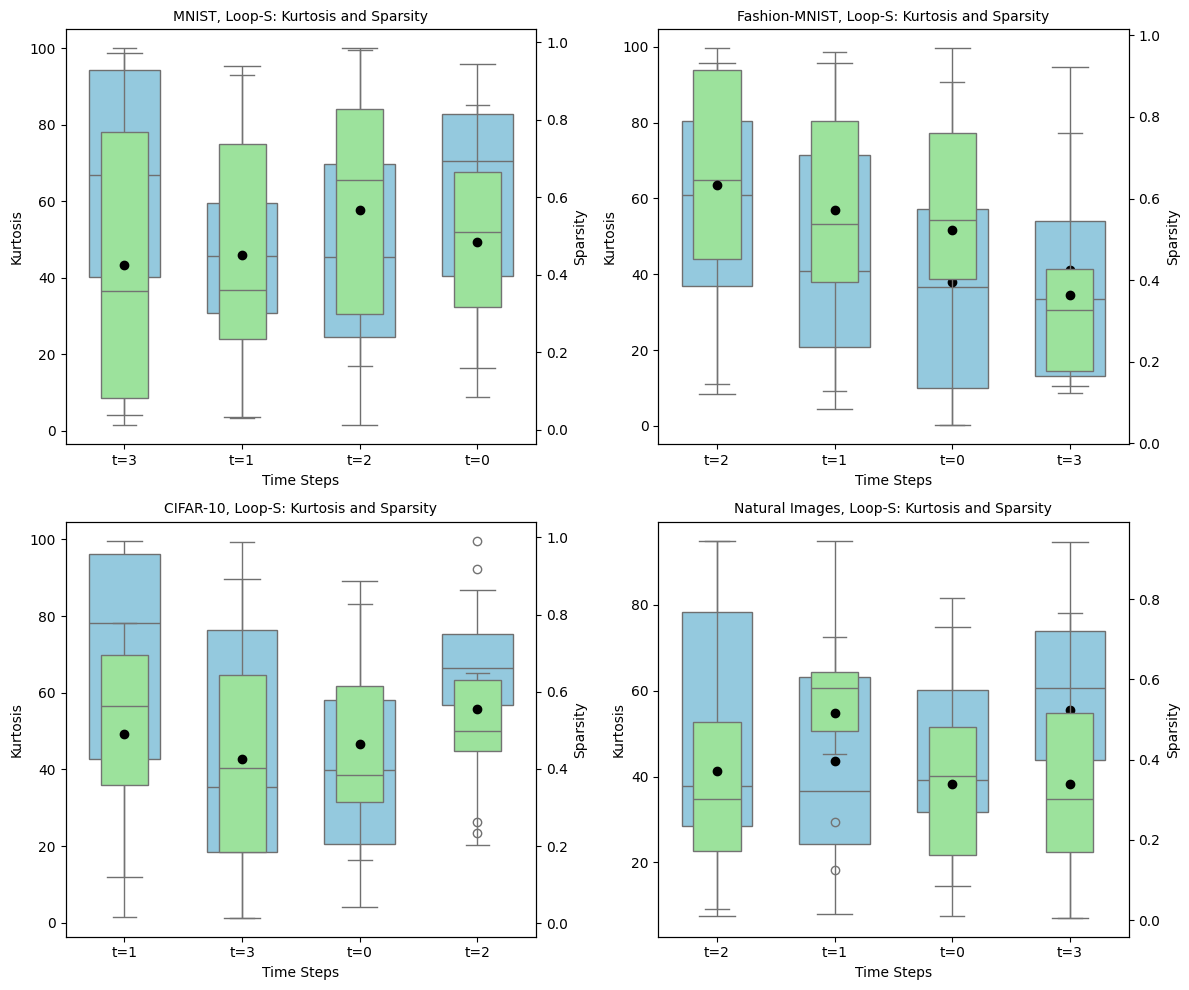

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example DataFrame
data = {
    'Dataset': np.random.choice(['MNIST', 'Fashion-MNIST', 'CIFAR-10', 'Natural Images'], 200),
    'Time Steps': np.random.choice(['t=0', 't=1', 't=2', 't=3'], 200),
    'Kurtosis': np.random.rand(200) * 100,
    'Sparsity': np.random.rand(200),
}
df = pd.DataFrame(data)

# Initialize the grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=False)
datasets = ['MNIST', 'Fashion-MNIST', 'CIFAR-10', 'Natural Images']

# Plot each dataset in a separate subplot
for ax, dataset in zip(axes.flatten(), datasets):
    subset = df[df['Dataset'] == dataset]
    
    # Create boxplot for Kurtosis
    sns.boxplot(
        x='Time Steps', y='Kurtosis', data=subset, ax=ax, color='skyblue',
        width=0.6, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )
    
    # Add secondary axis for Sparsity
    ax2 = ax.twinx()
    sns.boxplot(
        x='Time Steps', y='Sparsity', data=subset, ax=ax2, color='lightgreen',
        width=0.4, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )
    
    # Set labels and title
    ax.set_title(f'{dataset}, Loop-S: Kurtosis and Sparsity', fontsize=10)
    ax.set_ylabel('Kurtosis')
    ax2.set_ylabel('Sparsity')

# Adjust layout
plt.tight_layout()
plt.show()
